In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import tree

In [2]:
df = pd.read_csv('heart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


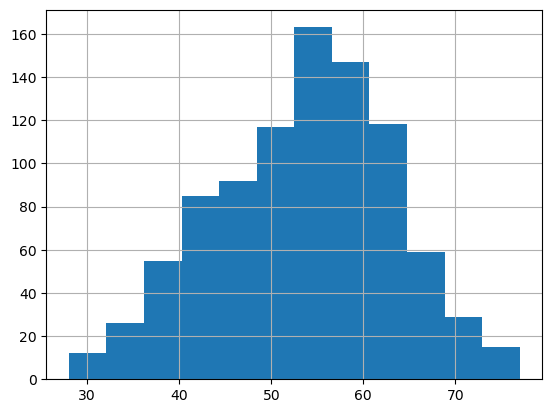

In [4]:
#Медианный возраст - 54 года
df['Age'].hist(bins=12)
plt.show()

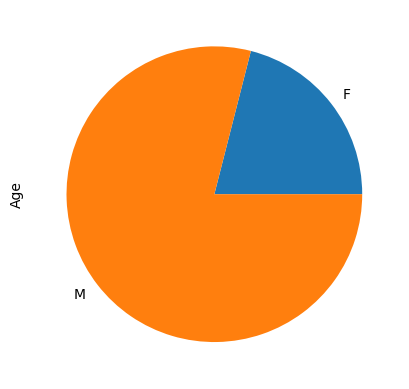

In [5]:
#Мужчин в данной выборке гораздо больше, нежели женщин
df.groupby(['Sex']).count()['Age'].plot(kind='pie', subplots=True)
plt.show()

In [34]:
#Преобразование категориальных переменных в числовые значения
transformer = make_column_transformer((OneHotEncoder(), list(df.select_dtypes(include=['object']).columns)), remainder='passthrough', sparse_threshold=0)
transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
transformed_df

,onehotencoder__Sex_F,onehotencoder__Sex_M,onehotencoder__ChestPainType_ASY,onehotencoder__ChestPainType_ATA,onehotencoder__ChestPainType_NAP,onehotencoder__ChestPainType_TA,onehotencoder__RestingECG_LVH,onehotencoder__RestingECG_Normal,onehotencoder__RestingECG_ST,onehotencoder__ExerciseAngina_N,...,onehotencoder__ST_Slope_Down,onehotencoder__ST_Slope_Flat,onehotencoder__ST_Slope_Up,remainder__Age,remainder__RestingBP,remainder__Cholesterol,remainder__FastingBS,remainder__MaxHR,remainder__Oldpeak,remainder__HeartDisease
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,40.0,140.0,289.0,0.0,172.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49.0,160.0,180.0,0.0,156.0,1.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,37.0,130.0,283.0,0.0,98.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,48.0,138.0,214.0,0.0,108.0,1.5,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,54.0,150.0,195.0,0.0,122.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,45.0,110.0,264.0,0.0,132.0,1.2,1.0
914,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,68.0,144.0,193.0,1.0,141.0,3.4,1.0
915,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,57.0,130.0,131.0,0.0,115.0,1.2,1.0
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,57.0,130.0,236.0,0.0,174.0,0.0,1.0


In [17]:
#Поиском по сетке найдем оптимальную глубину дерева решений
X_train, X_test, y_train, y_test = train_test_split(transformed_df.iloc[:, ~transformed_df.columns.isin(['remainder__HeartDisease'])], transformed_df['remainder__HeartDisease'], test_size = 0.2, random_state=42)
dt_model = DecisionTreeClassifier()
param_grid = {'max_depth': list(range(1, 20))}
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring='r2', cv=5).fit(X_train, y_train)
print(f"Лучшая глубина = {grid_search.best_params_['max_depth']}")
print(f'Лучшее значение r2_score при этой глубине на тренировачной выборке =', grid_search.best_score_)

Лучшая глубина = 4
Лучшее значение r2_score при этой глубине на тренировачной выборке = 0.30175565773824486


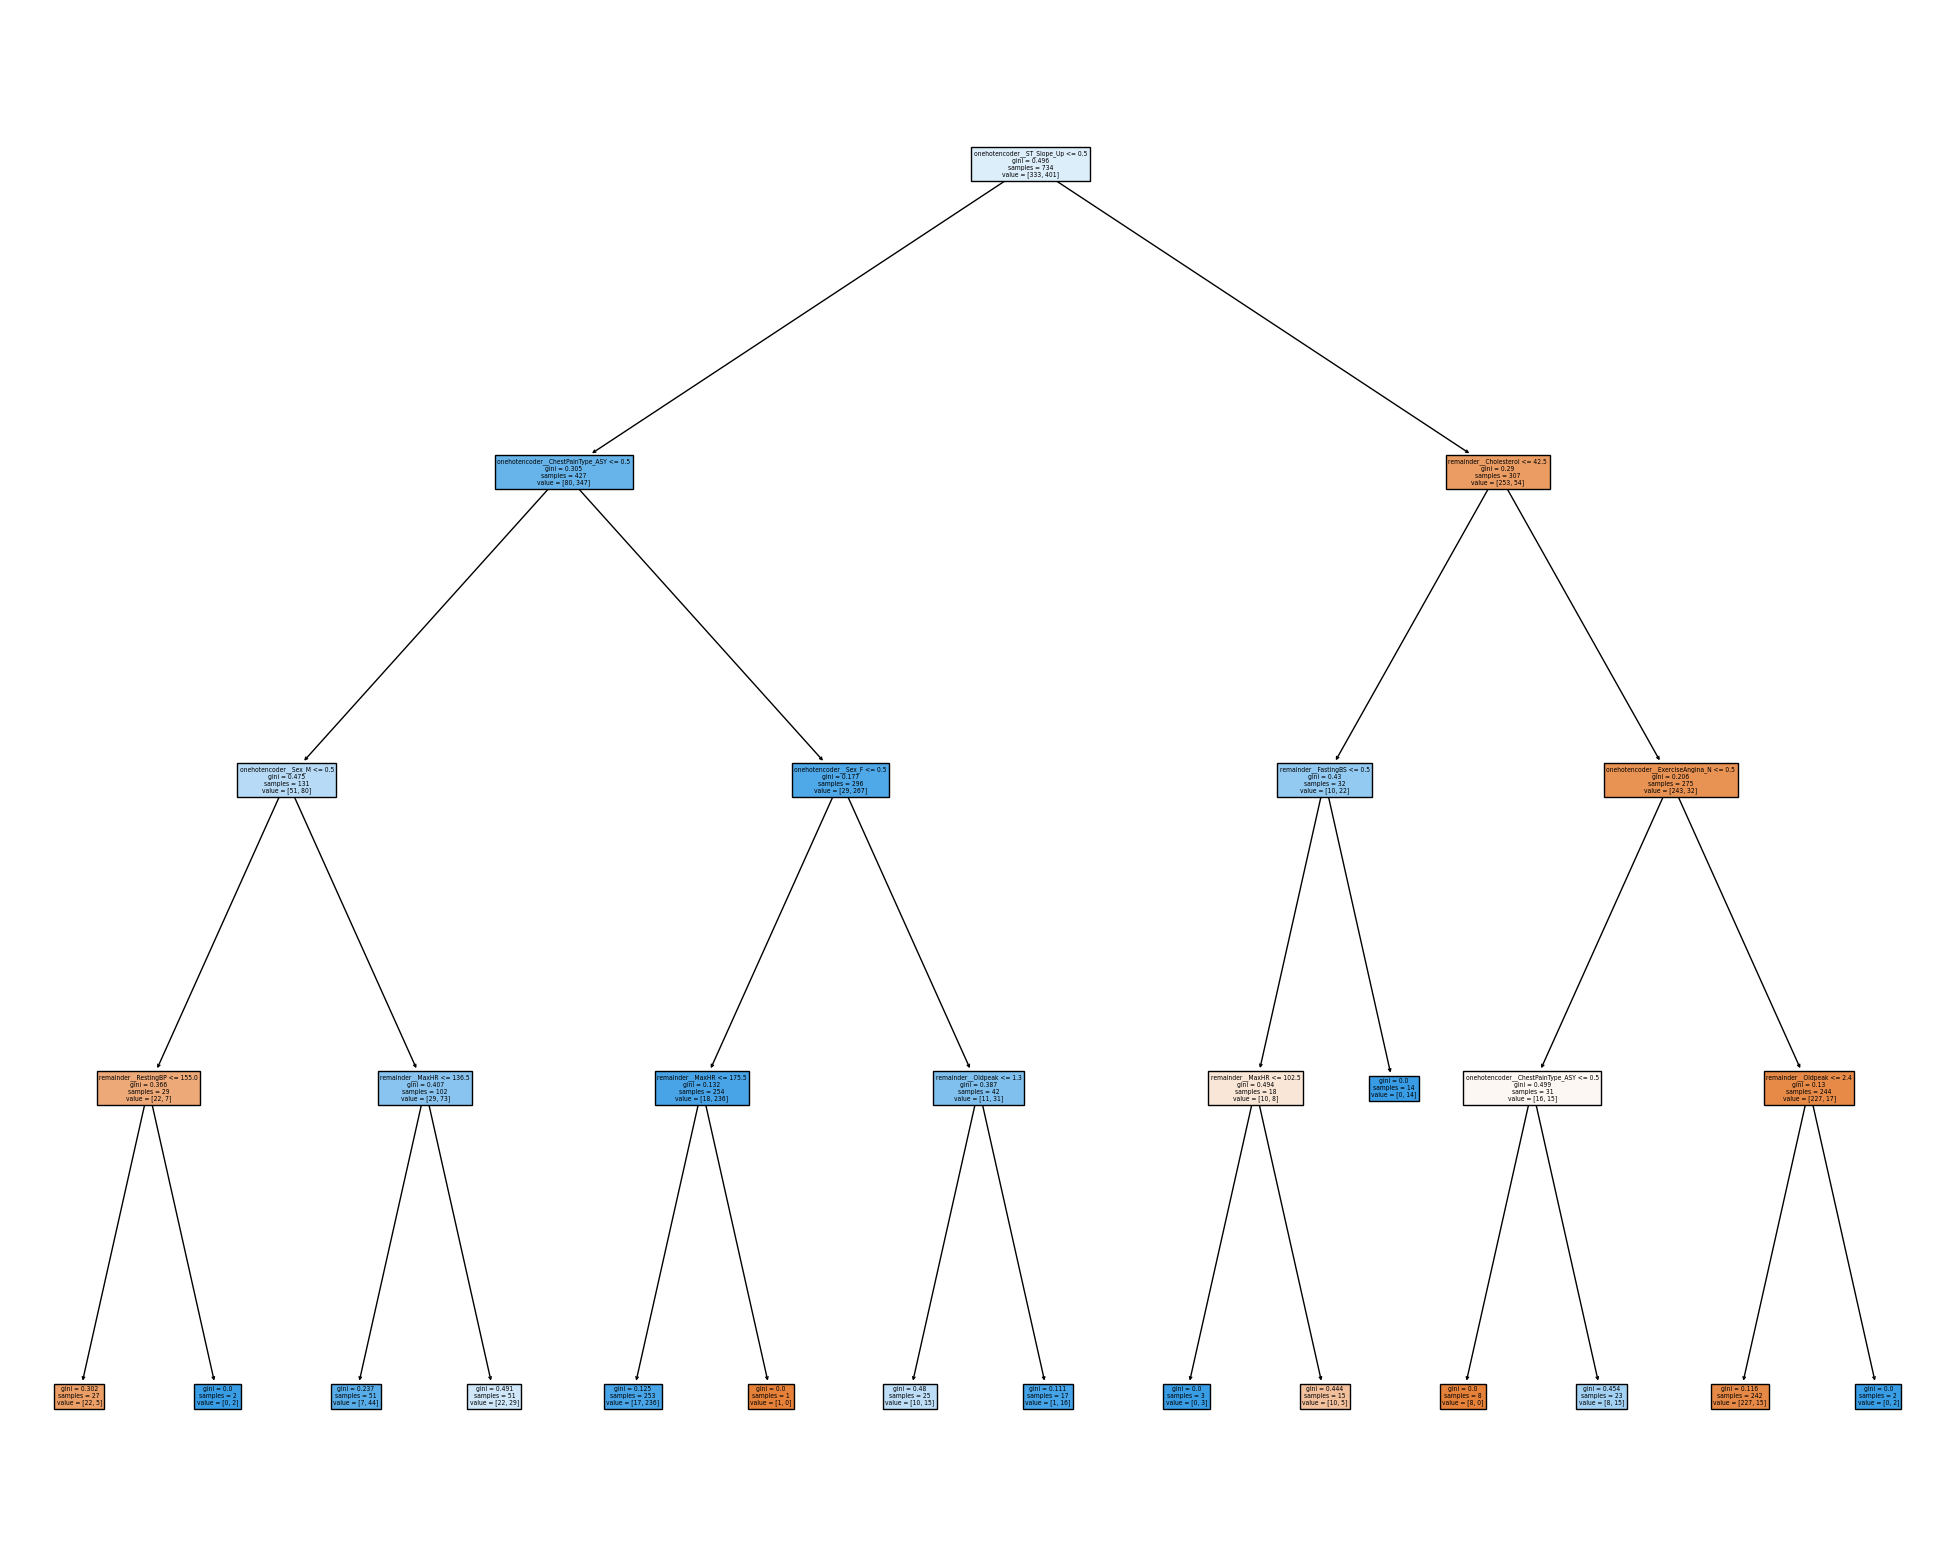

In [8]:
# Обучение модели дерева решений с глубиной 4
clf_dt = DecisionTreeClassifier(max_depth=4)
model_clf_dt = clf_dt.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_dt, feature_names=transformed_df.columns, filled=True)

In [9]:
# смотрим разницу факта и прогноза для дерева решений с глубиной равной 4
result_clf_dt = pd.DataFrame([np.array(y_test), clf_dt.predict(X_test)]).T
result_clf_dt.columns = ['y_test', 'y_pred']
result_clf_dt.head()

,y_test,y_pred
0,0.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0


In [10]:
#Вывод метрик для модели дерева решений с глубиной 4
print(classification_report(y_test, clf_dt.predict(X_test), target_names=['Здоров', 'Болен']))

              precision    recall  f1-score   support

      Здоров       0.84      0.86      0.85        77
       Болен       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



In [11]:
# Обучение модели случайного леса
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
# смотрим разницу факта и прогноза для случайного леса
result_clf_dt = pd.DataFrame([np.array(y_test), clf_dt.predict(X_test)]).T
result_clf_dt.columns = ['y_test', 'y_pred']
result_clf_dt.head()

,y_test,y_pred
0,0.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0


In [18]:
#Вывод метрик для модели случайного леса
print(classification_report(y_test, clf_rf.predict(X_test), target_names=['Здоров', 'Болен']))

              precision    recall  f1-score   support

      Здоров       0.84      0.87      0.85        77
       Болен       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



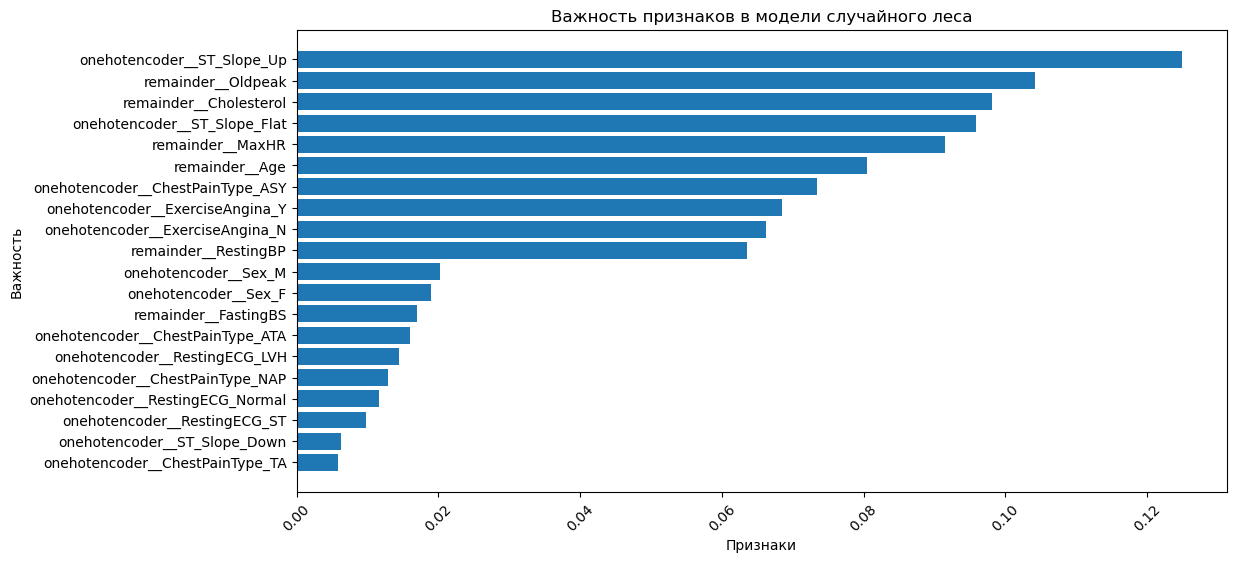

In [35]:
feature_importance_df = pd.DataFrame({'Признаки': X_test.columns, 'Важность признака': clf_rf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Важность признака', ascending=True)
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Признаки'], feature_importance_df['Важность признака'])
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели случайного леса')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Обучение модели бэггинг над деревом решний
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier())
bagging_clf.fit(X_train, y_train)
print(classification_report(y_test, bagging_clf.predict(X_test), target_names=['Здоров', 'Болен']))

              precision    recall  f1-score   support

      Здоров       0.77      0.87      0.82        77
       Болен       0.90      0.81      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [15]:
# Обучение модели стекинг из дерева решений, случайного леса и LinearSVC
estimators = [('dt', DecisionTreeClassifier()), ('rf', RandomForestClassifier()), ('svc', LinearSVC())]
stacking_clf = StackingClassifier(estimators=estimators)
stacking_clf.fit(X_train, y_train)
print(classification_report(y_test, stacking_clf.predict(X_test), target_names=['Здоров', 'Болен']))

e:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

      Здоров       0.85      0.88      0.87        77
       Болен       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



e:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Все модели показали себя +- одинаково